<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/rice-quality-classification/blob/master/klasifikasi_kualitas_beras_mobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi Kualitas Beras (mobileNet)**

---

Import dataset dari github

In [0]:
!apt-get install subversion > /dev/null
!svn export https://github.com/Soedirman-Machine-Learning/rice-quality-classification/trunk/dataset_n > /dev/null

Import library

In [0]:
from __future__ import absolute_import, print_function, division, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import math, os, sys
import itertools
import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd


import dataset

In [7]:
!ls dataset_n/
!ls dataset_n/train/ir64/
!ls dataset_n/train/ir64/medium/
!ls dataset_n/train/ir64/premium/
!ls dataset_n/train/ir64/tidak_layak/

test  train
medium	premium  tidak_layak
mi_001.jpg  mi_006.jpg	mi_011.jpg  mi_016.jpg	mi_021.jpg
mi_002.jpg  mi_007.jpg	mi_012.jpg  mi_017.jpg	mi_022.jpg
mi_003.jpg  mi_008.jpg	mi_013.jpg  mi_018.jpg	mi_023.jpg
mi_004.jpg  mi_009.jpg	mi_014.jpg  mi_019.jpg	mi_024.jpg
mi_005.jpg  mi_010.jpg	mi_015.jpg  mi_020.jpg	mi_025.jpg
pi_001.jpg  pi_006.jpg	pi_011.jpg  pi_016.jpg	pi_021.jpg
pi_002.jpg  pi_007.jpg	pi_012.jpg  pi_017.jpg	pi_022.jpg
pi_003.jpg  pi_008.jpg	pi_013.jpg  pi_018.jpg	pi_023.jpg
pi_004.jpg  pi_009.jpg	pi_014.jpg  pi_019.jpg	pi_024.jpg
pi_005.jpg  pi_010.jpg	pi_015.jpg  pi_020.jpg	pi_025.jpg
ti_001.jpg  ti_006.jpg	ti_011.jpg  ti_016.jpg	ti_021.jpg
ti_002.jpg  ti_007.jpg	ti_012.jpg  ti_017.jpg	ti_022.jpg
ti_003.jpg  ti_008.jpg	ti_013.jpg  ti_018.jpg	ti_023.jpg
ti_004.jpg  ti_009.jpg	ti_014.jpg  ti_019.jpg	ti_024.jpg
ti_005.jpg  ti_010.jpg	ti_015.jpg  ti_020.jpg	ti_025.jpg


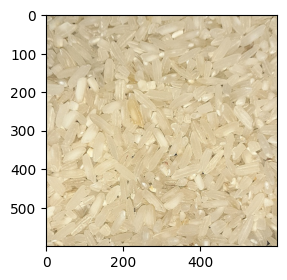

In [8]:
image =imread("dataset_n/train/ir64/medium/mi_019.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [16]:
#membuat dataset pelatihan
image_size=224
batch_size=32
base_dir=os.path.join('dataset_n/train/ir64')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen=datagen.flow_from_directory(
    base_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    subset='training'
)

val_gen=datagen.flow_from_directory(
    base_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    subset="validation"
)

#membuat dataset pengujian
X_test = []
y_test = []
labels = ['medium', 'premium', 'tidak_layak']

for i,label in enumerate(labels):
    folder = os.path.join("dataset_n/test/ir64",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_gen:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_gen:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 60 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (32, 224, 224, 3) (32, 3)
Bentuk array dari dataset validation (validasi) adalah: (15, 224, 224, 3) (15, 3)
Bentuk array dari dataset test (pengujian) adalah: (30, 224, 224, 3) (30,)


In [20]:
print (train_gen.class_indices)

labels_txt = '\n'.join(sorted(train_gen.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)
  

{'medium': 0, 'premium': 1, 'tidak_layak': 2}


In [22]:
!cat labels.txt

medium
premium
tidak_layak

In [0]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [25]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [26]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

In [28]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          294944    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 3,523,907
Trainable params: 295,043
Non-trainable params: 3,228,864
_________________________________________________________________


Pelatihan

In [29]:
history = model.fit_generator(train_gen, 
                    epochs=100, 
                    validation_data=val_gen)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
2/2 [==============================] - 2s 850ms/step - loss: 1.7426 - acc: 0.3500 - val_loss: 0.8075 - val_acc: 0.6667
Epoch 2/100
2/2 [==============================] - 1s 309ms/step - loss: 1.0567 - acc: 0.6833 - val_loss: 0.8665 - val_acc: 0.6667
Epoch 3/100
2/2 [==============================] - 1s 277ms/step - loss: 0.5601 - acc: 0.7000 - val_loss: 0.3151 - val_acc: 0.9333
Epoch 4/100
2/2 [==============================] - 1s 309ms/step - loss: 0.2349 - acc: 0.9833 - val_loss: 0.3223 - val_acc: 0.8667
Epoch 5/100
2/2 [==============================] - 1s 319ms/step - loss: 0.2340 - acc: 0.9333 - val_loss: 0.2562 - val_acc: 1.0000
Epoch 6/100
2/2 [==============================] - 1s 313ms/step - loss: 0.1359 - acc: 0.9833 - val_loss: 0.1399 - val_acc: 1.0000
Epoch 7/100
2/2 [==============================] - 1s 290ms/step - loss: 0.0561 - acc: 1.0000 - val_loss: 0.1275 - val_acc: 1.0000
Epoch 8

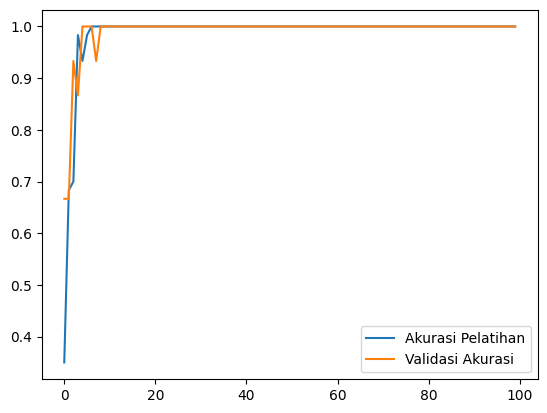

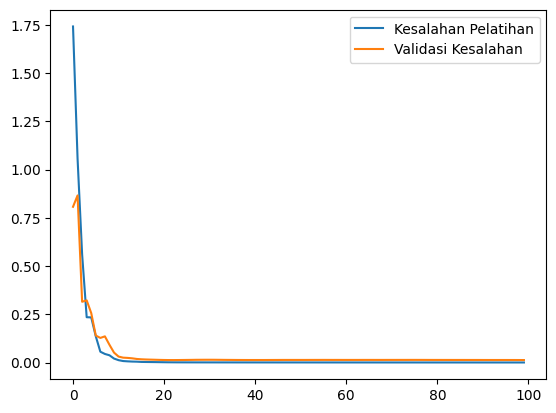

In [30]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [31]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))
print(train_gen)

Number of trainable variables = 4


In [36]:
#Prediksi Label Validasi dengan Pelatihan
n = 14
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [1. 0. 0.]
Prediksinya adalah [9.9954307e-01 2.1313159e-05 4.3565448e-04]


In [37]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3))

['loss', 'acc']
1/1 [==============================] - 0s 1ms/step - loss: 0.0609 - acc: 1.0000
[0.060878049582242966, 1.0]


In [38]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]


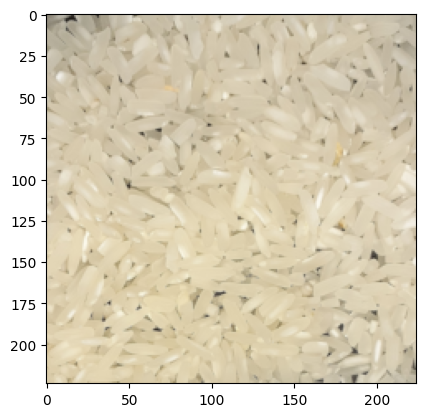

Label yang benar adalah: 1 : premium
Nilai yang diprediksi adalah: [4.3611199e-06 9.9998987e-01 5.7127404e-06]
Label yang diprediksi adalah: 1 : premium
Prediksi benar


In [39]:
n = 14 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


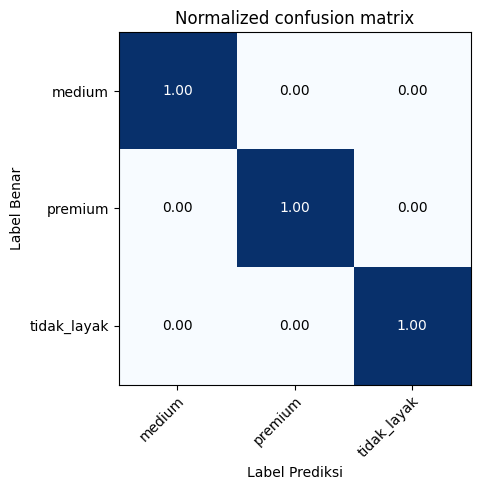

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [41]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_Kualitas_Beras_MobileNet_nf.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/model/assets
